In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalamos las siguientes librerias y modelos:

* **language_tool_python**: detectar y corregir errores gramaticales, ortográficos y de estilo en textos
* **contractions**: Expansión de contracciones en inglés
* **en_core_web_sm**: Modelo de Tokenización, Lematización, etc

In [6]:
!python -m spacy download en_core_web_sm
!pip install language_tool_python
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 84.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.4 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import spacy
import nltk
import language_tool_python
import contractions
from nltk.sentiment import SentimentIntensityAnalyzer
#from nltk.tokenize import sent_tokenize
#from nltk.tokenize import word_tokenize
from textblob import TextBlob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
nlp = spacy.load("en_core_web_sm")

In [8]:
#import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt_tab')
nltk.download("vader_lexicon")
lg_tool = language_tool_python.LanguageTool('en-US')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Configuración de librerias

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [10]:
ROOT_PATH = '/content/drive/Othercomputers/Mi MacBook Pro/Google Drive/tp3'

In [11]:
dataset_file_name = '/trainingandtestdata/big_tweets_cleaned.csv'

In [12]:
df = pd.read_csv(ROOT_PATH + dataset_file_name)

In [ ]:
df

,Text,Polarity
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",0
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,0
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",0
...,...,...
1599995,Just woke up. Having no school is the best feeling ever,4
1599996,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta,4
1599997,Are you ready for your MoJo Makeover? Ask me for details,4
1599998,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur,4


#***Definición de funciones***

* Normalización de tokens

In [13]:
# Definimos función para corregir palabras deformadas
def normalize_token(token):
  token = re.sub(r"(.)\1{2,}", r"\1\1", token)
  token_corrected = lg_tool.correct(token)
  return token_corrected

* Limpieza de texto

In [14]:
# Definimos función para realizar limpieza del texto
def clean_text(text):
  text = text.lower()

  text = contractions.fix(text)

  # Urls
  pattern = r'(?:\[[^\]]*\]\s*)'
  text = re.sub(pattern, '', text)
  pattern = r'(https|http)?://\S+'
  text = re.sub(pattern, '', text)

  # Etiquetas y Entidades HTML
  pattern = r'(<[^>]+>|&[a-zA-Z0-9#]+;)'
  text = re.sub(pattern, '', text)

  text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  doc = nlp(text) # tokenizamos
  #clean_text = ' '.join([normalize_token(token.lemma_) for token in doc if not token.is_stop and token.lemma_ not in ["not", "no", "n't"]])
  clean_text = ' '.join([token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in ["not", "no", "n't"]])
  #clean_text = ' '.join([normalize_token(token.lemma_) for token in doc if not token.is_stop])
  return clean_text

In [15]:
def report(y_train, train_pred, y_test, test_pred):
  fig, axes = plt.subplots(1, 2, figsize=(20, 5))

  print("Train")
  print(classification_report(y_train, train_pred))
  print("----------------------------------------------------------")
  print("Test")
  print(classification_report(y_test, test_pred))

  axes[0].set_title('Training')
  axes[1].set_title('Test')

  labels = sorted(y_train.unique())
  cm_train = confusion_matrix(y_train, train_pred, labels=labels)
  ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels).plot(ax=axes[0])

  labels = sorted(y_test.unique())
  cm_test = confusion_matrix(y_test, test_pred, labels=labels)
  ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels).plot(ax=axes[1])

  fig2, axes2 = plt.subplots(1, 2, figsize=(20, 5))
  axes2[0].set_title('Training')
  axes2[0].grid(True)
  axes2[1].set_title('Test')
  axes2[1].grid(True)

  train_pred_x = train_pred
  test_pred_x = test_pred

  if isinstance(train_pred, np.ndarray):
    train_pred_x = pd.DataFrame(train_pred)
  if isinstance(test_pred, np.ndarray):
    test_pred_x = pd.DataFrame(test_pred)

  sns.countplot(x=y_train, alpha=1, ax=axes2[0])
  sns.countplot(x=train_pred_x[0], alpha=0.7, color="orange", ax=axes2[0])

  sns.countplot(x=y_test, alpha=1, ax=axes2[1])
  sns.countplot(x=test_pred_x[0], alpha=0.7, color="orange", ax=axes2[1])

  plt.show()

In [38]:
def plot_cosine_similarity(matrix, labels=None, title="Matriz de Similitud del Coseno"):
    """
    matrix: matriz de vectores (ej. BoW, TF-IDF, embeddings)
    labels: nombres opcionales para los ejes (ej: índices de documentos)
    """

    # Calculamos la similitud coseno
    sim_matrix = cosine_similarity(matrix)

    # Configuramos la figura
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        sim_matrix,
        annot=False,
        cmap="viridis",
        xticklabels=labels,
        yticklabels=labels
    )

    plt.title(title)
    plt.xlabel("Documentos")
    plt.ylabel("Documentos")
    plt.tight_layout()
    plt.show()

* Análisis de sentimiento con TextBlob

In [16]:
def sentyment_textblob(texto):
    blob = TextBlob(texto)
    return blob.sentiment.polarity

*Probamos función de limpieza*

In [17]:
df_clean_test = df[:100].copy()

In [18]:
df_clean_test.head(50)

,Text,Polarity
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",0
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,0
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",0
5,@Kwesidei not the whole crew,0
6,Need a hug,0
7,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?",0
8,@Tatiana_K nope they didn't have it,0
9,@twittera que me muera ?,0


In [19]:
%%time
df_clean_test['Text'] = df_clean_test['Text'].apply(clean_text)
df_clean_test.head(50)

CPU times: user 860 ms, sys: 2.47 ms, total: 862 ms
Wall time: 876 ms


,Text,Polarity
0,switchfoot awww bummer shoulda get david carr day d,0
1,upset update facebook texte cry result school today blah,0
2,kenichan dive time ball manage save rest bound,0
3,body feel itchy like fire,0
4,nationwideclass behave mad,0
5,kwesidei crew,0
6,need hug,0
7,loltrish hey long time yes rain bit bit lol fine thank,0
8,tatianak nope,0
9,twittera que muera,0


#Entrenamiento

Separamos los datasets training y test

In [20]:
X = df['Text']
y = df['Polarity']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [22]:
%%time
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

CPU times: user 3h 41min 35s, sys: 15.2 s, total: 3h 41min 51s
Wall time: 3h 47min 1s


#**VADER Sentiment**

In [23]:
sia_model = SentimentIntensityAnalyzer()

In [24]:
def vader_sentiment_score(text):
    scores = sia_model.polarity_scores(text)
    return scores['compound']

In [25]:
def vader_sentiment_clasifier(polarity):
    if polarity >= 0:
        label = 4
    elif polarity < 0:
        label = 0

    return label

In [26]:
sia_y_train_pred = X_train.apply(vader_sentiment_score).apply(pd.Series)
sia_y_test_pred = X_test.apply(vader_sentiment_score).apply(pd.Series)

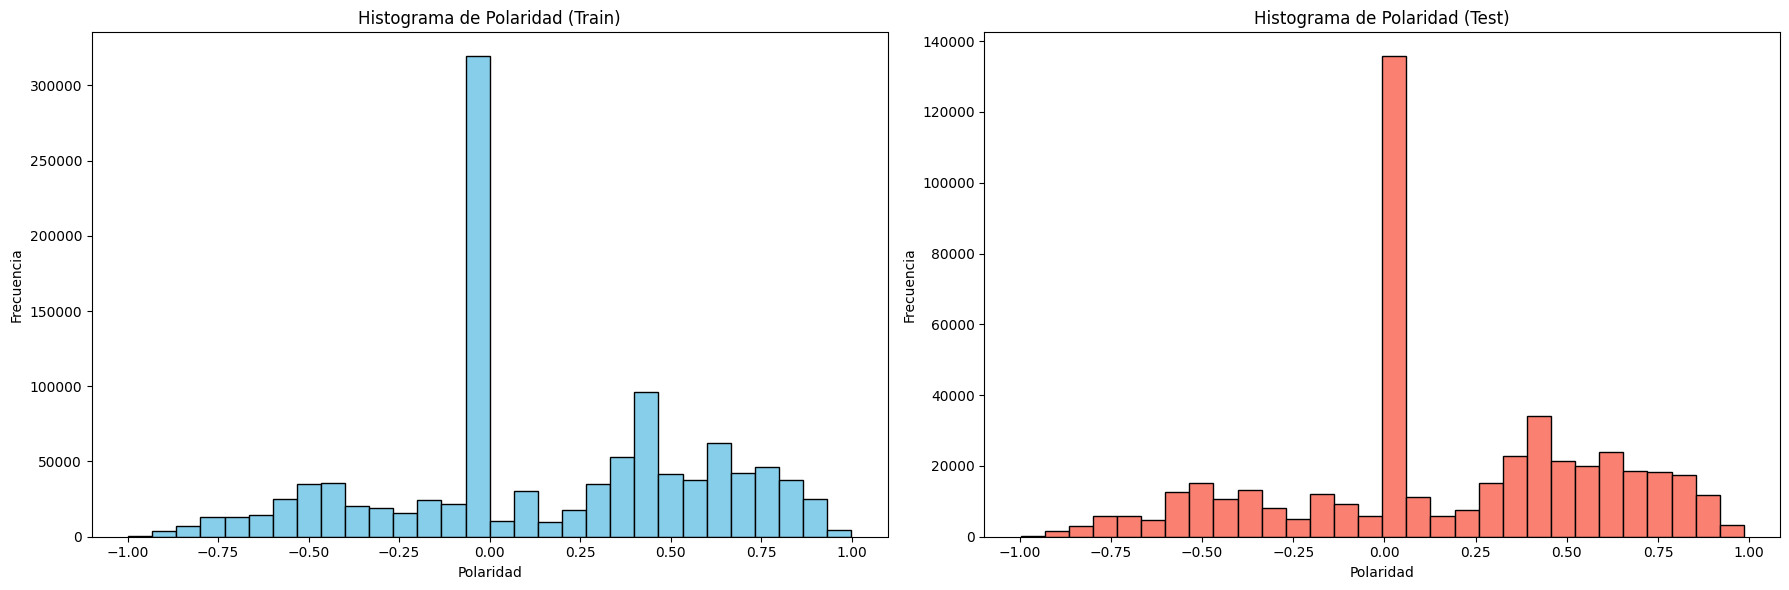

In [27]:
#Train
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.hist(sia_y_train_pred, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Polaridad (Train)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

#Test
plt.subplot(1, 2, 2)
plt.hist(sia_y_test_pred, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma de Polaridad (Test)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [28]:
sia_y_train_pred[0] = sia_y_train_pred[0].apply(lambda x: vader_sentiment_clasifier(x))
sia_y_test_pred[0] = sia_y_test_pred[0].apply(lambda x: vader_sentiment_clasifier(x))

Train
              precision    recall  f1-score   support

           0       0.80      0.38      0.51    560000
           4       0.59      0.90      0.72    560000

    accuracy                           0.64   1120000
   macro avg       0.69      0.64      0.61   1120000
weighted avg       0.69      0.64      0.61   1120000

----------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.80      0.38      0.51    240000
           4       0.59      0.90      0.72    240000

    accuracy                           0.64    480000
   macro avg       0.69      0.64      0.61    480000
weighted avg       0.69      0.64      0.61    480000



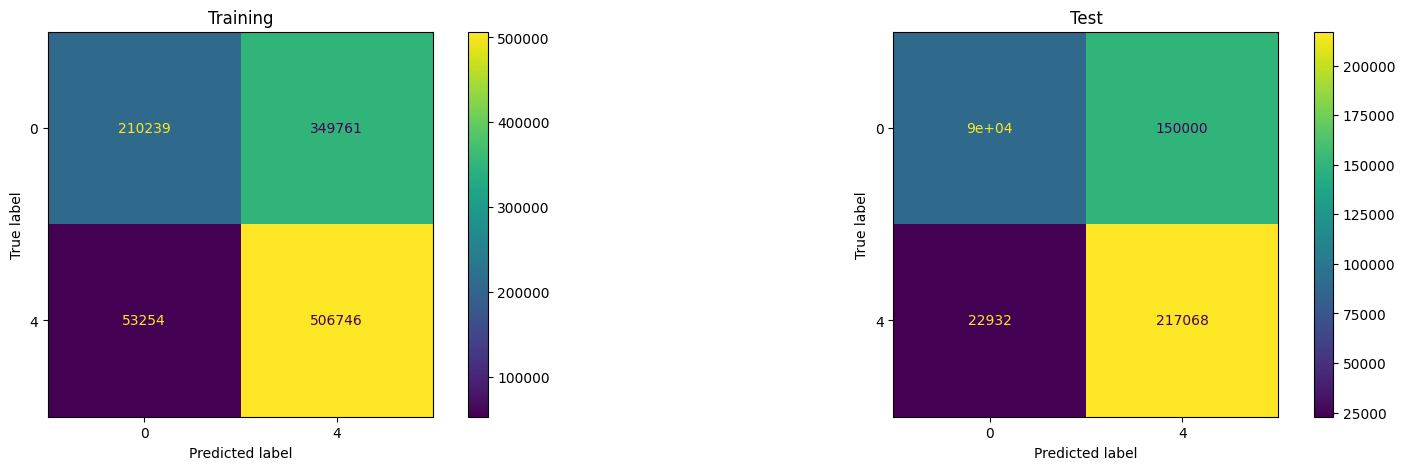

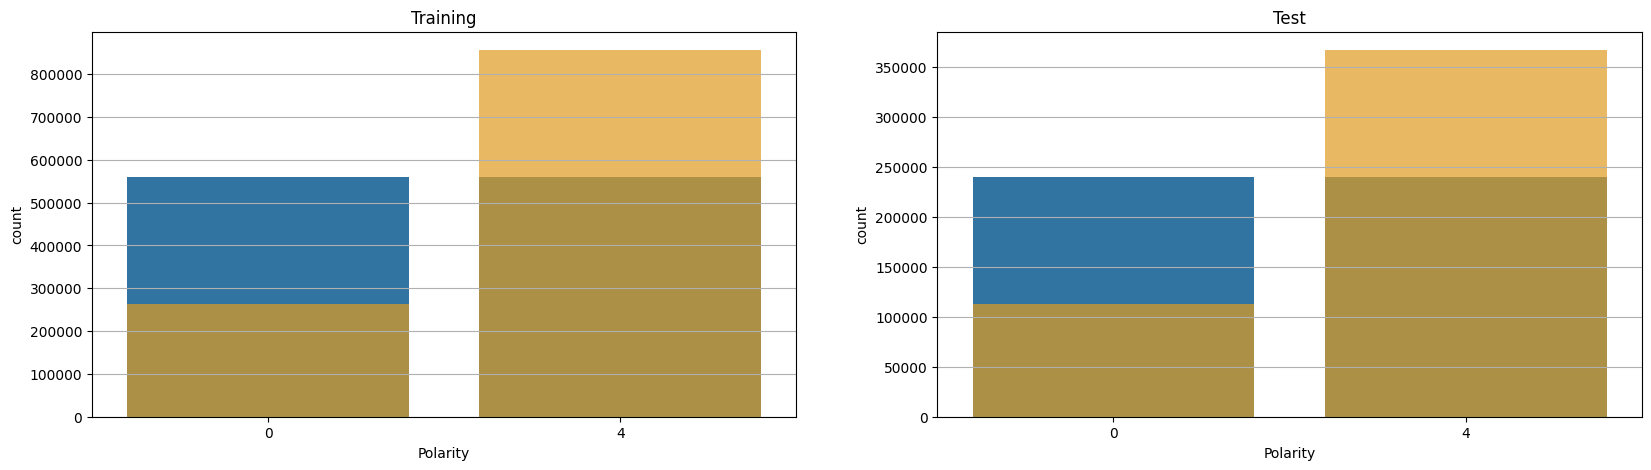

In [29]:
report(y_train, sia_y_train_pred, y_test, sia_y_test_pred)

#**TextBlob**

In [ ]:
tb_y_train_pred = X_train.apply(sentyment_textblob).apply(pd.Series)
tb_y_test_pred = X_test.apply(sentyment_textblob).apply(pd.Series)

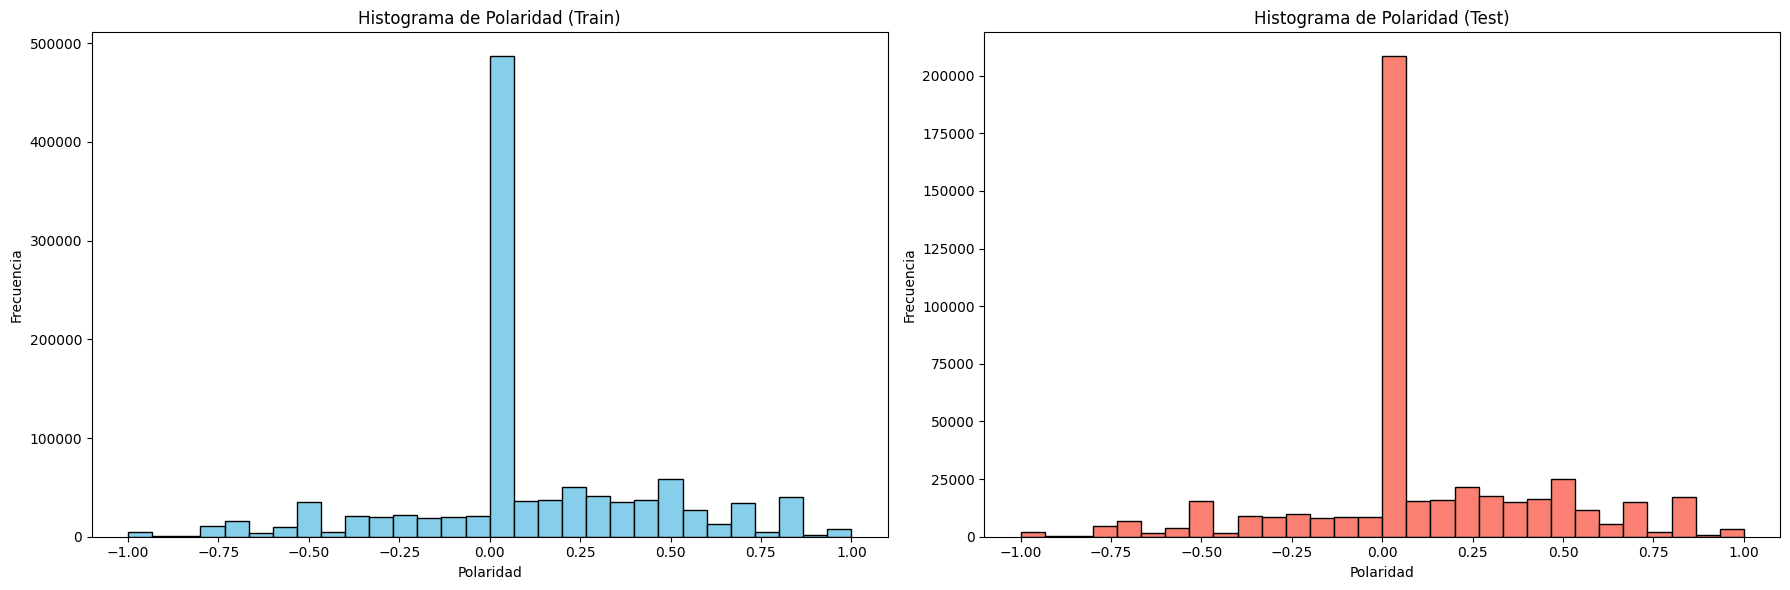

In [ ]:
#Train
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.hist(tb_y_train_pred, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Polaridad (Train)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

#Test
plt.subplot(1, 2, 2)
plt.hist(tb_y_test_pred, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma de Polaridad (Test)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
def feeling_clasifier(polarity):
    if polarity >= 0:
        return 4
    elif polarity < 0:
        return 0


In [ ]:
tb_y_train_pred[0] = tb_y_train_pred[0].apply(lambda x: feeling_clasifier(x))
tb_y_test_pred[0] = tb_y_test_pred[0].apply(lambda x: feeling_clasifier(x))

Train
              precision    recall  f1-score   support

           0       0.75      0.28      0.41    560000
           4       0.56      0.91      0.69    560000

    accuracy                           0.59   1120000
   macro avg       0.66      0.59      0.55   1120000
weighted avg       0.66      0.59      0.55   1120000

----------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.75      0.28      0.41    240000
           4       0.56      0.91      0.69    240000

    accuracy                           0.59    480000
   macro avg       0.66      0.59      0.55    480000
weighted avg       0.66      0.59      0.55    480000



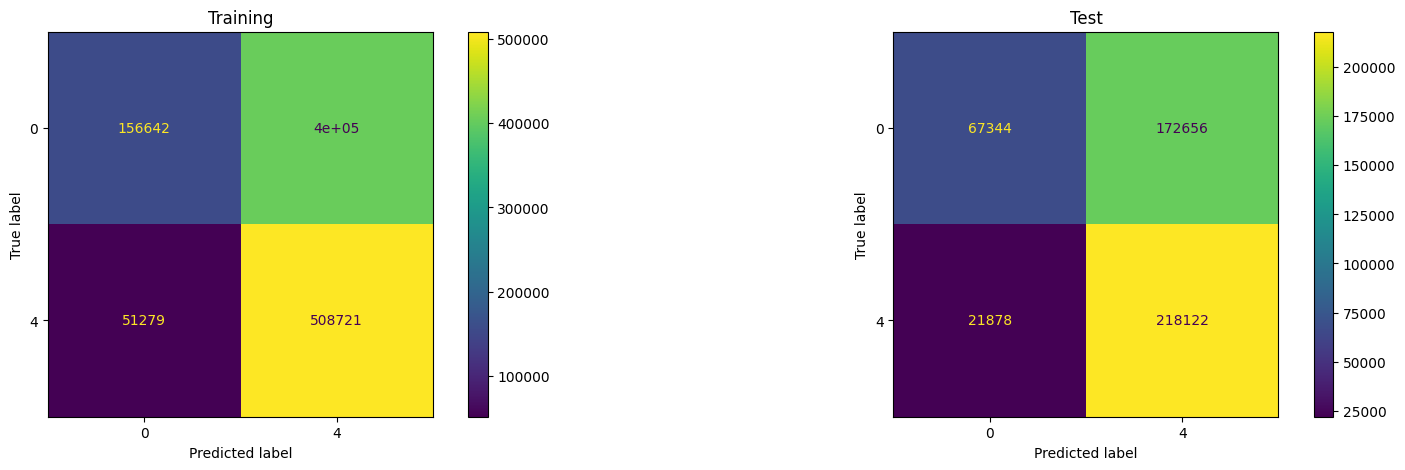

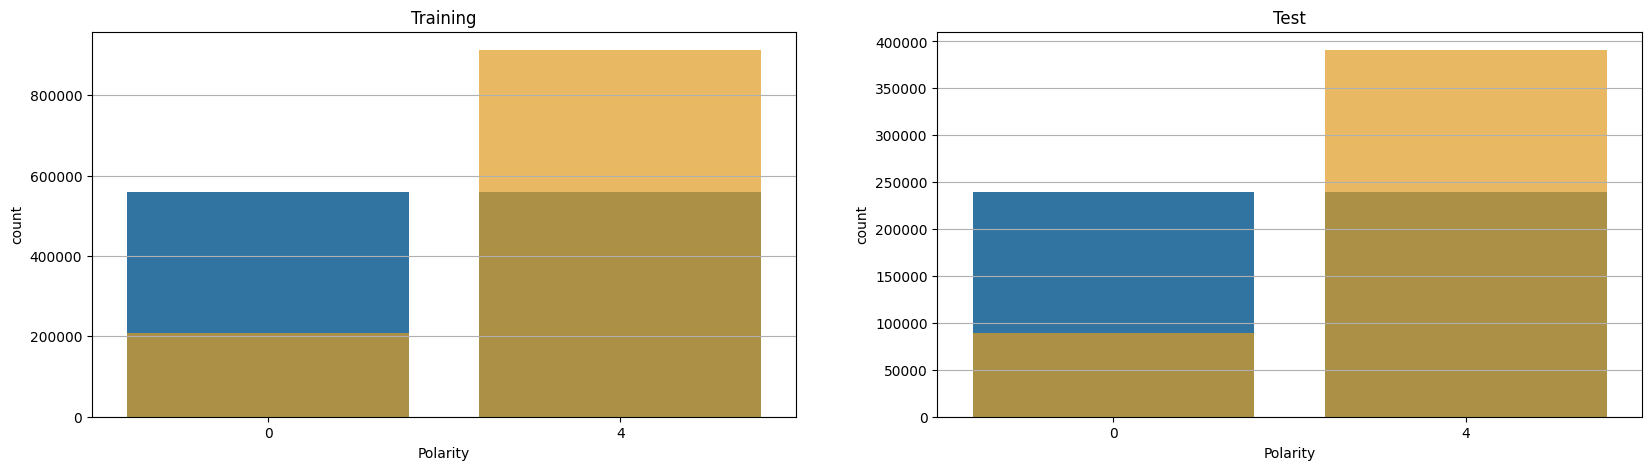

In [ ]:
report(y_train, tb_y_train_pred, y_test, tb_y_test_pred)

#**BoW + Bayes**

In [30]:
bow_vectorizer = CountVectorizer()

In [31]:
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [32]:
mnb_model = MultinomialNB()

In [33]:
mnb_model.fit(X_train_bow, y_train)

MultinomialNB()

In [34]:
mnb_y_train_pred = mnb_model.predict(X_train_bow)
mnb_y_test_pred = mnb_model.predict(X_test_bow)

Train
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    560000
           4       0.84      0.81      0.82    560000

    accuracy                           0.83   1120000
   macro avg       0.83      0.83      0.83   1120000
weighted avg       0.83      0.83      0.83   1120000

----------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.75      0.78      0.76    240000
           4       0.77      0.74      0.75    240000

    accuracy                           0.76    480000
   macro avg       0.76      0.76      0.76    480000
weighted avg       0.76      0.76      0.76    480000



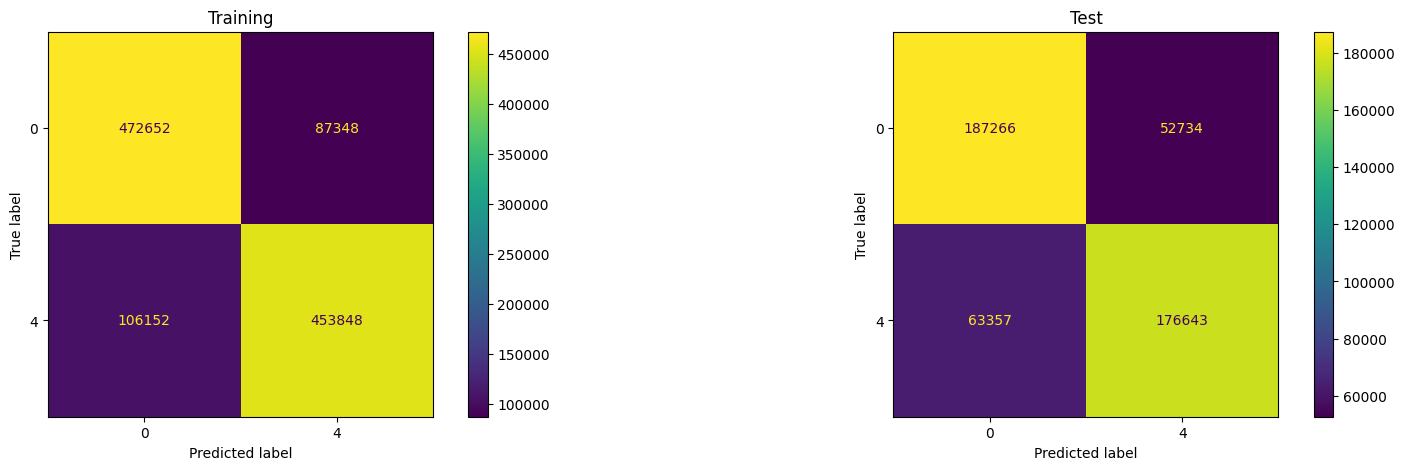

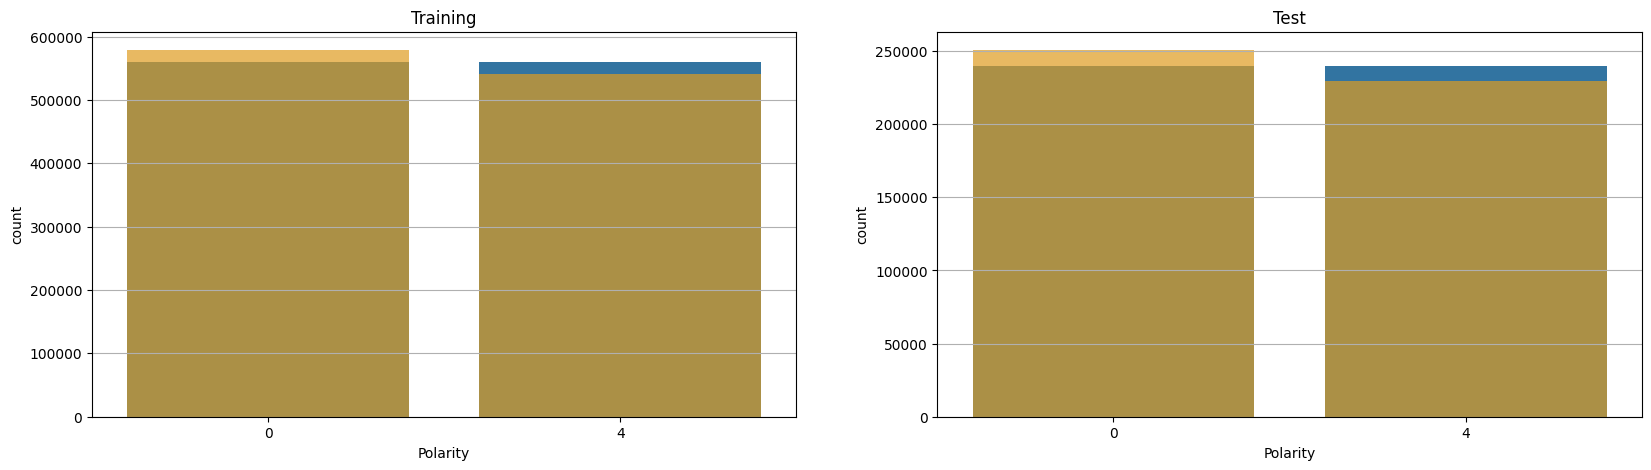

In [35]:
report(y_train, mnb_y_train_pred, y_test, mnb_y_test_pred)

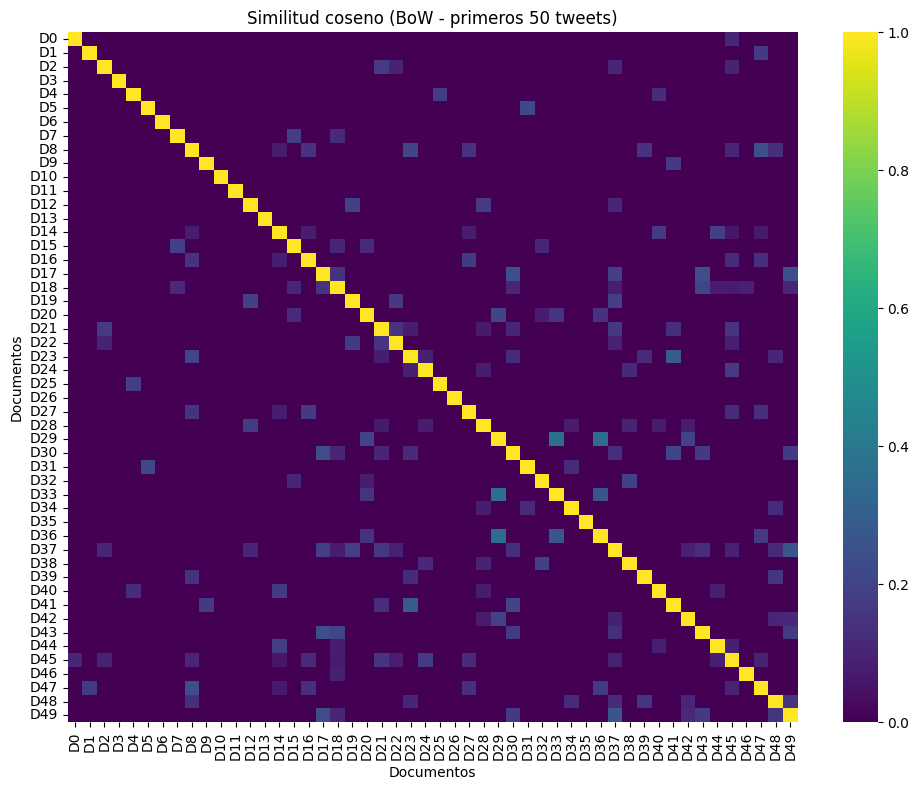

In [39]:
sample = X_train_bow[:50]

plot_cosine_similarity(sample.toarray(),
                       labels=[f"D{i}" for i in range(50)],
                       title="Similitud coseno (BoW - primeros 50 tweets)")

Se puede ver que los temas que los datos no son cercanos, lo que nos da a inferir la variedad de temas en los textos.

#**Tf-Idf + Regresión logistica**

In [40]:
tf_idf_vectorizer = TfidfVectorizer( )

In [41]:
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [42]:
lr_model = LogisticRegression(random_state=42, solver="liblinear", class_weight="balanced", max_iter=300)

In [43]:
lr_model.fit(X_train_tf_idf, y_train)

LogisticRegression(class_weight='balanced', max_iter=300, random_state=42,
                   solver='liblinear')

In [44]:
lr_y_train_pred = lr_model.predict(X_train_tf_idf)
lr_y_test_pred = lr_model.predict(X_test_tf_idf)

Train
              precision    recall  f1-score   support

           0       0.83      0.79      0.81    560000
           4       0.80      0.83      0.82    560000

    accuracy                           0.81   1120000
   macro avg       0.81      0.81      0.81   1120000
weighted avg       0.81      0.81      0.81   1120000

----------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.78      0.75      0.76    240000
           4       0.76      0.79      0.77    240000

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



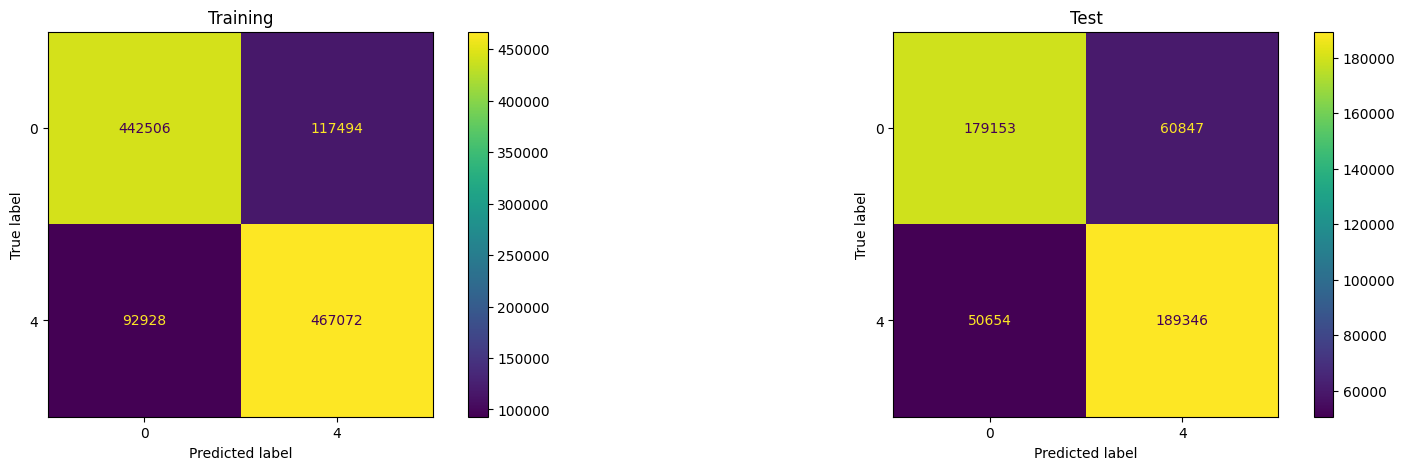

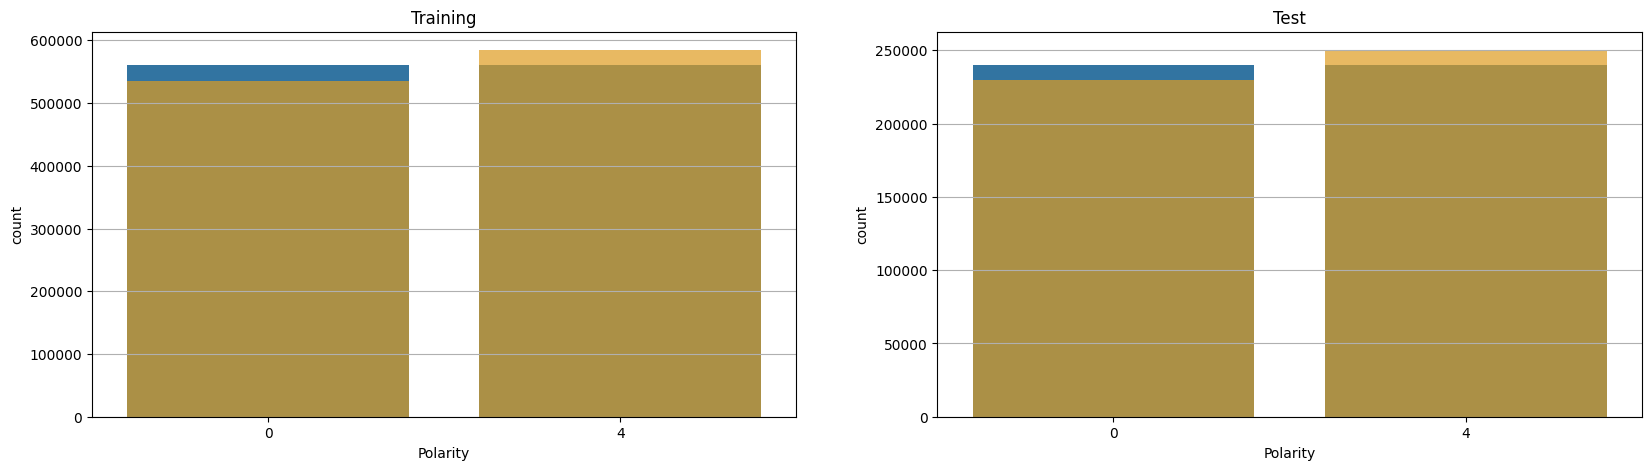

In [45]:
report(y_train, lr_y_train_pred, y_test, lr_y_test_pred)

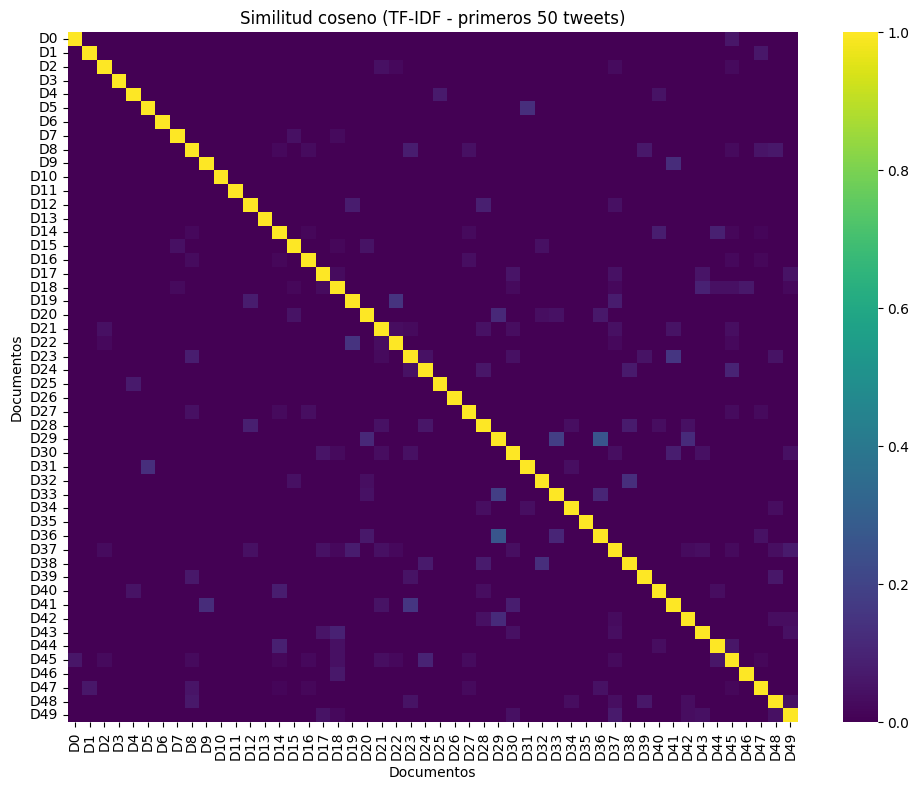

In [47]:
plot_cosine_similarity(X_train_tf_idf[:50].toarray(),
                       labels=[f"D{i}" for i in range(50)],
                       title="Similitud coseno (TF-IDF - primeros 50 tweets)")

Se puede ver que los temas que los datos no son cercanos, lo que nos da a inferir la variedad de temas en los textos.

#**Conclusiones**

###Modelos pre-entrenados

Presentan un performance consistente, con accuracy iguales tanto en train como en test.

De estos *Vader Sentiment* presenta una mejor performance frente a *TextBlob* con un accuracy *Train: 0.64 y Test: 0.64* frente a *Train: 0.59 y Test: 0.59*.

###Modelos entrenados

Presentan igualmente performance similares con overfitting.

***BoW + Naive Bayes***

Train accuracy: 0.83
Test accuracy: 0.76
diferencia: 0.07

***TF-IDF + Logistic Regression***

Train accuracy: 0.81
Test accuracy: 0.77
diferencia: 0.04

*TF-IDF + Logistic Regression* muestra un menor overfitting en téminos generales, por lo cual puede tender a generalizar mejor.